# 1.- Descargar librerias

In [1]:
%pip install numpy pandas tensorflow tensorflowjs matplotlib seaborn zipfile pillow scikit-learn gradio playsound#instalar directamiente desde el cmd con permisos de administrador o ejecutar el IDE de uso como administrador

ERROR: Invalid requirement: 'gradio#instalar'


# 2.-Importar librerias de librerias

In [1]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re


from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import load_model, Sequential
from keras.utils import to_categorical, load_img
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dropout, Dense, Activation,GlobalAveragePooling2D,Dropout

In [5]:
%pip list

Package                      Version
---------------------------- -----------
absl-py                      1.4.0
aiofiles                     23.2.1
aiohttp                      3.8.5
aiosignal                    1.3.1
altair                       5.1.1
anyio                        3.7.1
app                          0.0.1
array-record                 0.4.1
asgiref                      3.6.0
asttokens                    2.2.1
astunparse                   1.6.3
async-timeout                4.0.2
attrs                        23.1.0
backcall                     0.2.0
bcrypt                       4.0.1
button                       0.0.3.post3
cachetools                   5.3.1
certifi                      2022.12.7
charset-normalizer           2.1.1
chex                         0.1.82
click                        8.1.6
colorama                     0.4.6
comm                         0.1.3
contourpy                    1.0.6
cycler                       0.11.0
Cython                       0.29

# 3.- Definir Contastantes

In [2]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


base_path = "dataset-resized/"
categories = {0: 'battery', 1: 'biological', 2: 'cardboard', 3: 'glass', 4: 'metal', 5: 'paper', 6: 'plastic',7: 'trash'}

# 4.- Cargar datos a Dataframe

In [7]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])

    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')
print(df)
# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

                    filename  category
0       battery/battery1.jpg         0
1      battery/battery10.jpg         0
2     battery/battery100.jpg         0
3     battery/battery101.jpg         0
4     battery/battery102.jpg         0
...                      ...       ...
7638       trash/trash95.jpg         7
7639       trash/trash96.jpg         7
7640       trash/trash97.jpg         7
7641       trash/trash98.jpg         7
7642       trash/trash99.jpg         7

[7643 rows x 2 columns]
number of elements =  7643


In [27]:
df

,filename,category
0,trash/trash636.jpg,7
1,biological/biological726.jpg,1
2,paper/paper523.jpg,5
3,plastic/plastic565.jpg,6
4,paper/paper139.jpg,5
...,...,...
7638,plastic/plastic713.jpg,6
7639,glass/glass355210210_1.jpg,3
7640,glass/glass1023.jpg,3
7641,battery/battery627.jpg,0


# 4.1.- Visualizar imagenes de manera aleatoria

battery/battery604.jpg


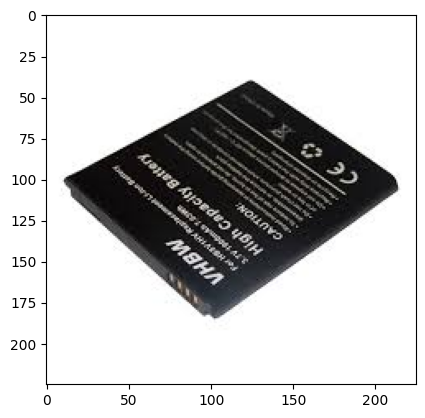

In [28]:
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

# 4.2.- Visualizar cantidad de datos que contiene cada clase

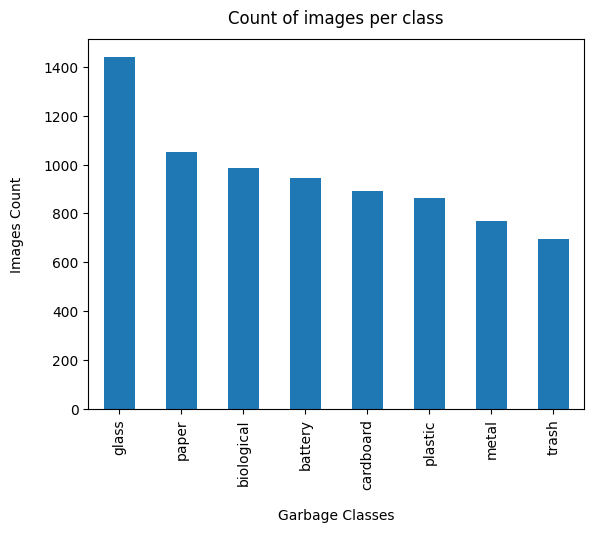

In [29]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

# 5.- Seperar datos del Dataframe

In [30]:
df["category"] = df["category"].replace(categories)


train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  764 validate size =  764 test size =  765


# 6.- Deep learning(Uso del modelo pre entrenado mobilenetv2) fecha(4/9/2023)
### Si se descargar los pesos de el modelo en https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
Mostrar en carpeta


In [3]:
import keras.applications.mobilenet_v2 as mobilenetv2

mobilenetv2_layer = mobilenetv2.MobileNetV2(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                    weights = 'weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')

# We don't want to train the imported weights
mobilenetv2_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def mobilenetv2_preprocessing(img):
    return mobilenetv2.preprocess_input(img)

model.add(Lambda(mobilenetv2_preprocessing))

model.add(mobilenetv2_layer)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 8)                 10248     
                                                                 
Total params: 2,268,232
Trainable params: 10,248
Non-tra

# 7.- Entrenamiento

# 7.1.- Aumento de datos(tecnica de entrenmiento)

In [58]:
batch_size=64

train_datagen = ImageDataGenerator(
    #rotation_range=30,
    #shear_range=0.1,
    #zoom_range=0.3,
    #horizontal_flip=True,
    #vertical_flip = True,
    #width_shift_range=0.2,
    #height_shift_range=0.2
    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 6114 validated image filenames belonging to 8 classes.


In [33]:
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 764 validated image filenames belonging to 8 classes.


In [34]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False  # No necesitamos mezclar el conjunto de prueba para evaluarlo
)

Found 765 validated image filenames belonging to 8 classes.


# 7.2 Early stopping (tecnica de entrenamiento de datos)

In [35]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

In [59]:
EPOCHS = 50
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50


C:\Users\hombr\AppData\Local\Temp\ipykernel_21244\3154049270.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


95/95 [==============================] - 71s 727ms/step - loss: 1.1194 - categorical_accuracy: 0.6129 - val_loss: 0.4345 - val_categorical_accuracy: 0.8565
Epoch 2/50
95/95 [==============================] - 67s 710ms/step - loss: 0.5192 - categorical_accuracy: 0.8187 - val_loss: 0.3456 - val_categorical_accuracy: 0.8807
Epoch 3/50
95/95 [==============================] - 70s 732ms/step - loss: 0.4369 - categorical_accuracy: 0.8479 - val_loss: 0.2945 - val_categorical_accuracy: 0.8977
Epoch 4/50
95/95 [==============================] - 69s 730ms/step - loss: 0.3629 - categorical_accuracy: 0.8717 - val_loss: 0.2715 - val_categorical_accuracy: 0.9091
Epoch 5/50
95/95 [==============================] - 68s 711ms/step - loss: 0.3339 - categorical_accuracy: 0.8802 - val_loss: 0.2571 - val_categorical_accuracy: 0.9091
Epoch 6/50
95/95 [==============================] - 67s 705ms/step - loss: 0.3022 - categorical_accuracy: 0.8967 - val_loss: 0.2409 - val_categorical_accuracy: 0.9205
Epoch 7/5

1/1 [==============================] - 1s 531ms/step


# 8.- Rendimiento

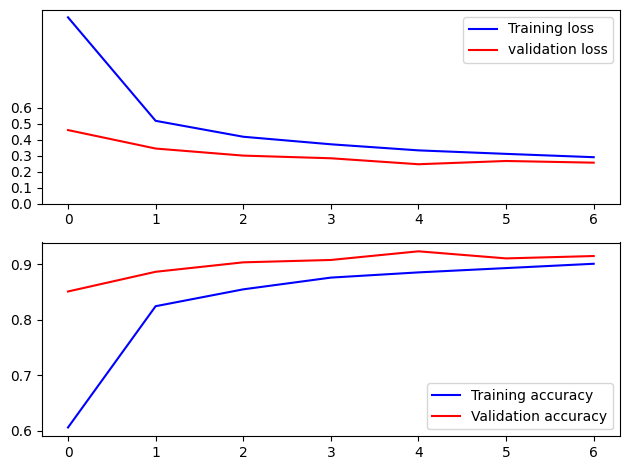

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 9.-Testeo

12/12 [==============================] - 8s 650ms/step


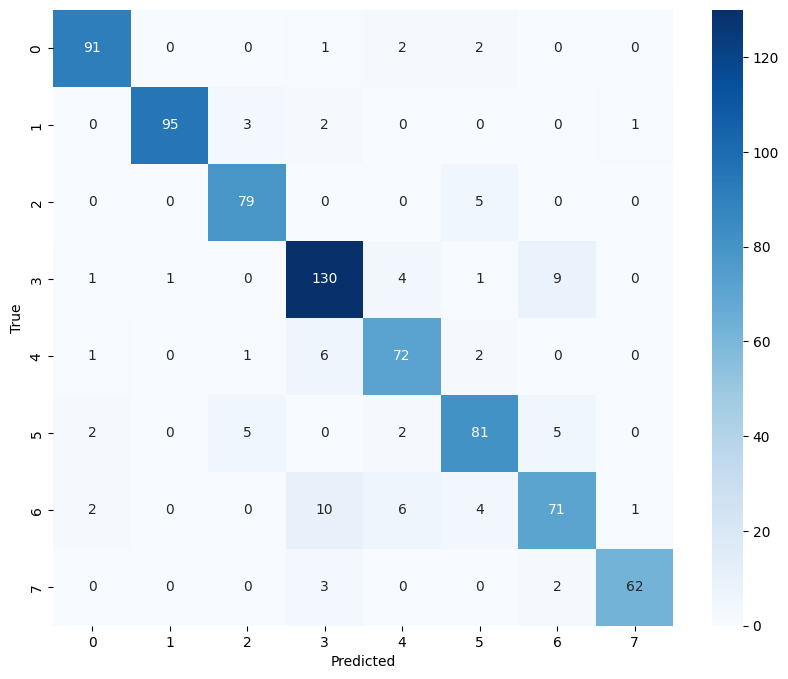

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes  # Obtener las etiquetas verdaderas del generador de prueba

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [39]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8901960784313725


In [40]:
loss = model.evaluate(test_generator, verbose=0)[0]
print(f'Loss: {loss}')

Loss: 0.3156473934650421


In [41]:
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'F1 Score: {f1}')

F1 Score: 0.8901129724481195


# 10.- Guardar Modelo

In [42]:
model.save("modelo.h5")

# 11.- Exportar el modelo en js

In [ ]:
!mkdir carpeta_salida

Ya existe el subdirectorio o el archivo carpeta_salida.


In [ ]:
!tensorflowjs_converter --input_format keras modelo.h5 carpeta_salida

# 12.- Diseño Interfaz

In [4]:
model = tf.keras.models.load_model('modelo.h5')

In [10]:
import gradio as gr

C:\Users\hombr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
categories_traduccion = {0: 'Bateria', 1: 'Biologico', 2: 'carton', 3: 'vidrio', 4: 'metal', 5: 'papel', 6: 'plastico',7: 'basura'}

1/1 [==============================] - 0s 31ms/step
voces_auron/3.wav
voces_auron/3.wav
Reproduciendo: voces_auron/3.wav
Reproducción completa
1/1 [==============================] - 0s 28ms/step
voces_auron/2.wav
voces_auron/2.wav
Reproduciendo: voces_auron/2.wav
Reproducción completa
1/1 [==============================] - 0s 29ms/step
voces_auron/2.wav
voces_auron/2.wav
Reproduciendo: voces_auron/2.wav
Reproducción completa
1/1 [==============================] - 0s 29ms/step
voces_auron/6.wav
voces_auron/6.wav
Reproduciendo: voces_auron/6.wav
Reproducción completa
1/1 [==============================] - 0s 28ms/step
voces_auron/6.wav
voces_auron/6.wav
Reproduciendo: voces_auron/6.wav
Reproducción completa
1/1 [==============================] - 0s 30ms/step
voces_auron/5.wav
voces_auron/5.wav
Reproduciendo: voces_auron/5.wav
Reproducción completa
1/1 [==============================] - 0s 30ms/step
voces_auron/3.wav
voces_auron/3.wav
Reproduciendo: voces_auron/3.wav
Reproducción completa

In [12]:
def clasificar(img):
  img_reshape = img.reshape(-1,224,224,3)
  pred = model.predict(img_reshape)[0]
  return {categories_traduccion[i]:float(pred[i]) for i in range(8)}


interfaz = gr.Interface(fn=clasificar, inputs=gr.inputs.Image(shape=(224,224),source='upload',label='Captura desde cámara'),
                        outputs=gr.outputs.Label(num_top_classes=7),capture_session=True).launch(debug = False,share='True')


C:\Users\hombr\AppData\Local\Temp\ipykernel_18364\2716927368.py:7: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  interfaz = gr.Interface(fn=clasificar, inputs=gr.inputs.Image(shape=(224,224),source='upload',label='Captura desde cámara'),
C:\Users\hombr\AppData\Local\Temp\ipykernel_18364\2716927368.py:7: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  interfaz = gr.Interface(fn=clasificar, inputs=gr.inputs.Image(shape=(224,224),source='upload',label='Captura desde cámara'),
C:\Users\hombr\AppData\Local\Temp\ipykernel_18364\2716927368.py:8: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  outputs=gr.outputs.Label(num_top_classes=7),capture_session=True).launch(debug = False,share='True')
C:\Users\hombr\AppData\Local\Temp\ipykernel

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


1/1 [==============================] - 1s 597ms/step


In [7]:
from playsound import playsound
import gradio as gr

# Crea un diccionario que mapea categorías a archivos de audio correspondientes
audio_files = {
    0: 'voces_auron/1.wav',
    1: 'voces_auron/2.wav',
    2: 'voces_auron/3.wav',
    3: 'voces_auron/4.wav',
    4: 'voces_auron/5.wav',
    5: 'voces_auron/6.wav',
    6: 'voces_auron/7.wav',
    7: 'voces_auron/8.wav'
}

# Inicializa pygame para la reproducción de audio
def clasificar(img):
    img_reshape = img.reshape(-1, 224, 224, 3)
    pred = model.predict(img_reshape)[0]
    predictions = {categories_traduccion[i]: float(pred[i]) for i in range(8)}
    
    # Encuentra la categoría con la mayor probabilidad
    categoria_predicha = max(predictions, key=predictions.get)
    
    categorias_audio = {
        'Bateria': audio_files[0],
        'Biologico': audio_files[1],
        'carton': audio_files[2],
        'vidrio': audio_files[3],
        'metal': audio_files[4],
        'papel': audio_files[5],
        'plastico': audio_files[6],
        'basura': audio_files[7]
    }
    
    # Reproduce el archivo de audio correspondiente a la categoría predicha
    audio_file = categorias_audio.get(categoria_predicha)
    if audio_file:
        reproducir_audio(audio_file)
    return predictions

def reproducir_audio(audio_file):
    try:
        print(f"Reproduciendo: {audio_file}")
        playsound(audio_file)
        print("Reproducción completa")
    except Exception as e:
        print(f"Error al reproducir audio: {e}")

interfaz = gr.Interface(
    fn=clasificar,
    inputs=gr.inputs.Image(shape=(224, 224), source='upload', label='Captura desde cámara'),
    outputs=gr.outputs.Label(num_top_classes=7),
    capture_session=True
)

interfaz.launch(debug=False, share=True)

C:\Users\hombr\AppData\Local\Temp\ipykernel_27532\1266736797.py:52: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gr.inputs.Image(shape=(224, 224), source='upload', label='Captura desde cámara'),
C:\Users\hombr\AppData\Local\Temp\ipykernel_27532\1266736797.py:52: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Image(shape=(224, 224), source='upload', label='Captura desde cámara'),
C:\Users\hombr\AppData\Local\Temp\ipykernel_27532\1266736797.py:53: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  outputs=gr.outputs.Label(num_top_classes=7),
C:\Users\hombr\AppData\Local\Temp\ipykernel_27532\1266736797.py:53: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'a

Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


1/1 [==============================] - 0s 31ms/step
Reproduciendo: voces_auron/6.wav
Reproducción completa
